In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import pandas as pd
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
from torchvision import transforms
#import pretrainedmodels
import math
import sys
import pickle
#from arch import GeM, L2Norm
%config InlineBackend.figure_format ='retina'


In [3]:
class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(1).expand_as(x)
        return x

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=torch.clamp(self.p, min=0.1), eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [4]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class customDataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []
        self.labels_mapping = {}  # Từ điển để ánh xạ nhãn chuỗi sang số nguyên

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    # Chuẩn hóa đường dẫn bằng cách bỏ phần "/kaggle/input/deepfashion1/"
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    # Loại bỏ cấp MEN dư thừa nếu tồn tại
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên (MEN)
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name, item_id và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Bỏ qua dòng đầu tiên chứa số lượng và header
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]  # Đường dẫn ảnh từ TXT
            item_id = parts[1]
            evaluation_status = parts[2]

            # Chỉ lấy các ảnh có evaluation_status = train
            if evaluation_status == "train" and image_name in self.image_paths:
                # Thêm nhãn vào từ điển ánh xạ nếu chưa có
                if item_id not in self.labels_mapping:
                    self.labels_mapping[item_id] = len(self.labels_mapping)
                label_index = self.labels_mapping[item_id]  # Chỉ số nhãn
                self.data.append((label_index, self.image_paths[image_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None  # Skip this sample if there's an error
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [5]:
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

train_dataset = customDataset(ROOT_DIR, CSV_PATH, transform = transform)

In [6]:
print(f"Tổng số mẫu trong dataset: {len(train_dataset)}")


Tổng số mẫu trong dataset: 25882


In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Cấu hình các tham số
BS = 48
NUM_WORKERS = 16

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=NUM_WORKERS)


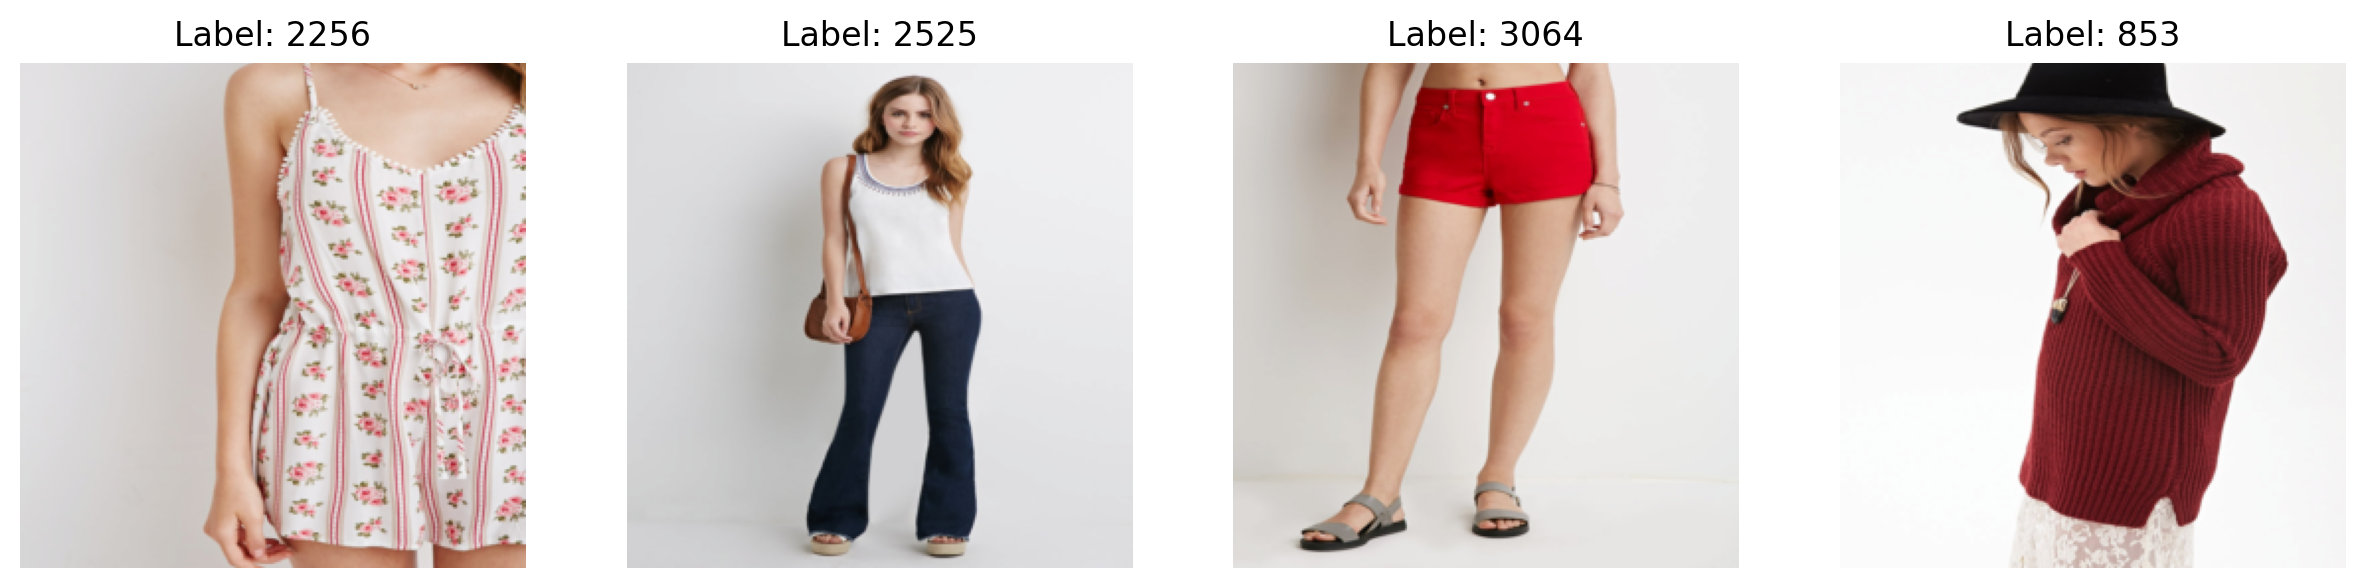

In [10]:
# Kiểm tra một batch dữ liệu
import matplotlib.pyplot as plt

# Kiểm tra một batch dữ liệu
def show_batch(data_loader, n=4):
    images, labels = next(iter(data_loader))  # Lấy một batch
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # Chuyển tensor về numpy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Undo Normalize
        img = img.clip(0, 1)  # Giới hạn giá trị pixel từ 0 đến 1
        axes[i].imshow(img)
        axes[i].axis('off')
        # Hiển thị label dưới ảnh
        axes[i].set_title(f"Label: {labels[i]}")
    plt.show()

show_batch(train_loader)

In [11]:
# Lấy tất cả các nhãn từ dataset
all_labels = [label for _, label in train_dataset]

# Lấy số lượng lớp (số lượng nhãn duy nhất)
NUM_CLASSES = len(set(all_labels))  # Dùng set để loại bỏ nhãn trùng lặp
print(f"Số lượng lớp: {NUM_CLASSES}")


Số lượng lớp: 3997


In [26]:
from torchvision import models

arch = models.resnet152
model_name = f'{arch.__name__}'
print(model_name)  # Kết quả: resnet152


resnet152


In [ ]:
# arch = models.resnet101
# model_name = f'{arch.__name__}'

In [ ]:
# arch = models.resnet50
# model_name = f'{arch.__name__}'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
from torchvision.models import ResNet152_Weights
archcut = nn.Sequential(
    *list(arch(weights=ResNet152_Weights.DEFAULT).children())[:-2], nn.AdaptiveAvgPool2d(1),nn.Flatten(), nn.Linear(2048, NUM_CLASSES))
model = archcut.to(device)

In [ ]:
# from torchvision.models import ResNet101_Weights
# archcut = nn.Sequential(
#     *list(arch(weights=ResNet101_Weights.DEFAULT).children())[:-2], nn.AdaptiveAvgPool2d(1),nn.Flatten(), nn.Linear(2048, NUM_CLASSES))
# model = archcut.to(device)

In [ ]:
# from torchvision.models import ResNet50_Weights
# archcut = nn.Sequential(
#     *list(arch(weights=ResNet50_Weights.DEFAULT).children())[:-2], nn.AdaptiveAvgPool2d(1),nn.Flatten(), nn.Linear(2048, NUM_CLASSES))
# model = archcut.to(device)

In [34]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from torch.cuda.amp import GradScaler, autocast

# Hàm huấn luyện mô hình
def train_model_no_eval(model, train_loader, criterion, optimizer, device, epochs=10, mixup_alpha=0.4):
    """
    Huấn luyện mô hình PyTorch với Mixup và FP16, không đánh giá trên validation.

    Args:
        model: Mô hình PyTorch.
        train_loader: DataLoader cho tập huấn luyện.
        criterion: Hàm loss (vd: nn.CrossEntropyLoss).
        optimizer: Optimizer (vd: Adam).
        device: Thiết bị (cuda hoặc cpu).
        epochs: Số lượng epoch huấn luyện.
        mixup_alpha: Tham số alpha cho Mixup augmentation.

    Returns:
        model: Mô hình đã được huấn luyện.
        train_losses: Loss trên tập huấn luyện cho mỗi epoch.
    """
    # Mixup function
    def mixup_data(images, labels, alpha):
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
        index = torch.randperm(images.size(0)).to(device)
        mixed_images = lam * images + (1 - lam) * images[index, :]
        labels_a, labels_b = labels, labels[index]
        return mixed_images, labels_a, labels_b, lam
    
    # FP16 GradScaler
    scaler = GradScaler()
    
    # Chuyển mô hình sang device
    model.to(device)
    
    # Biến lưu loss
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        print(f"Epoch {epoch+1}/{epochs} - Training...")
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Áp dụng Mixup
            mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, mixup_alpha)
            
            # Huấn luyện với FP16
            optimizer.zero_grad()
            with autocast():
                outputs = model(mixed_images)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            
            # Backpropagation và cập nhật trọng số
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            
            # In thông tin từng batch nếu cần
            print(f"Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4f}")
    
    return model, train_losses



In [35]:
# Hyperparameters
EPOCHS = 20
LR = 1e-3
MIXUP_ALPHA = 0.4

# Loss function và Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Huấn luyện mô hình
trained_model, train_losses = train_model_no_eval(model, train_loader, criterion, optimizer, device, EPOCHS, MIXUP_ALPHA)


Epoch 1/20 - Training...


/tmp/ipykernel_23/2206690146.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_23/2206690146.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch [1/540] - Loss: 8.0521
Batch [2/540] - Loss: 8.1441
Batch [3/540] - Loss: 8.1878
Batch [4/540] - Loss: 8.2539
Batch [5/540] - Loss: 8.1106
Batch [6/540] - Loss: 8.2390
Batch [7/540] - Loss: 8.1072
Batch [8/540] - Loss: 8.2475
Batch [9/540] - Loss: 8.0617
Batch [10/540] - Loss: 8.2465
Batch [11/540] - Loss: 8.1302
Batch [12/540] - Loss: 8.1340
Batch [13/540] - Loss: 8.3045
Batch [14/540] - Loss: 8.1615
Batch [15/540] - Loss: 8.1069
Batch [16/540] - Loss: 8.1783
Batch [17/540] - Loss: 8.1552
Batch [18/540] - Loss: 8.1789
Batch [19/540] - Loss: 7.9611
Batch [20/540] - Loss: 8.2006
Batch [21/540] - Loss: 8.1085
Batch [22/540] - Loss: 8.2461
Batch [23/540] - Loss: 8.0492
Batch [24/540] - Loss: 8.1149
Batch [25/540] - Loss: 8.1606
Batch [26/540] - Loss: 7.9420
Batch [27/540] - Loss: 8.1835
Batch [28/540] - Loss: 8.0321
Batch [29/540] - Loss: 8.2146
Batch [30/540] - Loss: 7.9672
Batch [31/540] - Loss: 8.1446
Batch [32/540] - Loss: 8.2822
Batch [33/540] - Loss: 8.1775
Batch [34/540] - Lo

In [37]:
torch.save(model.state_dict(), '/kaggle/working/finetuneResnet152.pth')

In [ ]:
previous_model_name

'resnet152_i200_l1000-256'